In [1]:
import segmentation_models as sm

2023-02-22 10:38:48.958839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 10:38:49.715401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 10:38:49.715539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 10:38:50.094609: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-22 10:38:53.216073: W tensorflow/stream_executor/platform/de

Segmentation Models: using `keras` framework.


In [2]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

In [3]:

keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

In [4]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [5]:
# loading image data...
def data_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (sx,sy))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset


In [6]:
# loading image data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = cv2.resize(image, (sx,sy))
        image_dataset.append(image)
    return image_dataset

In [7]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = data_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
#image_dataset = np.expand_dims(image_dataset, axis = 3) # per creare la giusta struttura
mask_dataset = np.array(mask_dataset)
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [8]:
print(image_dataset.shape)
print(mask_dataset_encoded.shape)
print("Image shape: ", image_dataset[0].shape)
print("Mask shape: ", mask_dataset_encoded[0].shape)
print("Max pixel value in image is: ", image_dataset.max()) #255 perchè non è normalizzata
print("Labels in the mask are : ", np.unique(mask_dataset_encoded)) # 0,1,2,3,4

(1688, 128, 128, 3)
(1688, 128, 128, 1)
Image shape:  (128, 128, 3)
Mask shape:  (128, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [9]:

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255.

In [10]:
#Split training datafrom sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")    

Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [11]:
#Le maschere devono avere il formato dell'ultimo layer del modello (256x256x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat =val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))
print("shape precedente: ", y_train.shape)
print("shape attuale: ", y_train_cat.shape)


shape precedente:  (1080, 128, 128, 1)
shape attuale:  (1080, 128, 128, 5)


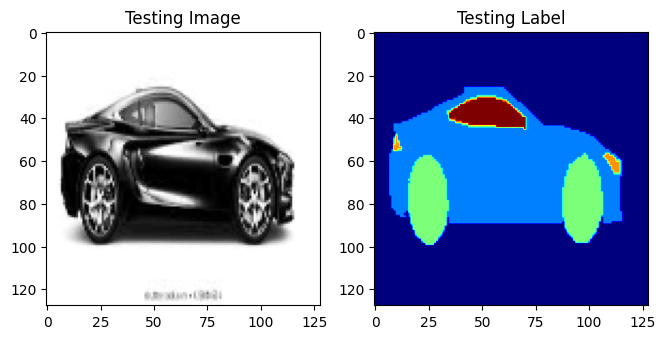

In [12]:
#Sanity check delle immagini
n = random.randint(0, len(X_test)-1)
test_img = X_train[n]
ground_truth=y_train[n]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [13]:
"""# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input,Reshape, LeakyReLU,Add,ReLU,GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
 
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

from keras.layers import AveragePooling2D

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X"""

"# Building Unet by dividing encoder and decoder into blocks\n\nfrom keras.models import Model\nfrom keras.layers import Input,Reshape, LeakyReLU,Add,ReLU,GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda\nfrom keras.optimizers import Adam\nfrom keras.layers import Activation, MaxPool2D, Concatenate\ndef conv_block(X,filters,block):\n    # resiudal block with dilated convolutions\n    # add skip connection at last after doing convoluion operation to input X\n    \n    b = 'block_'+str(block)+'_'\n    f1,f2,f3 = filters\n    X_skip = X\n    # block_a\n \n    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),\n                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)\n    X = BatchNormalization(name=b+'batch_norm_a')(X)\n    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)\n    # block_b\n    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),\n                      padding='sa

In [14]:
# multiclass segmentation with non overlapping class masks (your classes + background)
# define model
BACKBONE='vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [15]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(128, 128, 3)
(1080, 128, 128, 3)
(338, 128, 128, 3)
(1080, 128, 128, 5)
(338, 128, 128, 5)


In [20]:
# define model
model = sm.PSPNet(BACKBONE,input_shape=input_shape, classes=n_classes, activation='softmax', encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())

ValueError: Wrong shape (128, 128, 3), input H and W should be divisible by `48`

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(1080, 128, 128, 3)
(338, 128, 128, 3)
(1080, 128, 128, 5)
(338, 128, 128, 5)


In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)

from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
#Fase di TRAINING del modello, early stopping con pazienza a 5
csv_logger = CSVLogger('PSPNet.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
__path__ = os.path.join("..",'PSPNet.hdf5')
m_save = ModelCheckpoint(__path__, save_best_only=True, monitor='val_loss', mode='min')

# Some times, it is useful to train only randomly initialized decoder in order not to damage weights of properly trained encoder with huge gradients
# during first steps of training. 
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=False)

set_trainable(model) # set all layers trainable and recompile model

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=False)

     


2023-02-22 10:18:36.051431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 212336640 exceeds 10% of free system memory.
2023-02-22 10:18:36.536432: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 353894400 exceeds 10% of free system memory.


Epoch 1/25


ValueError: in user code:

    File "/home/elena/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/elena/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/elena/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/elena/.local/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/elena/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/elena/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 384, 384, 3), found shape=(None, 128, 128, 3)
